### MPS - Matrix Product States
 Um estado genérico de um sistema de N partículas pode ser escrito como 
$\begin{gather}
    \ket{\psi} = \sum_{j_1, j_2\cdots j_N}C_{j_1, j_2\cdots j_N}\ket{\sigma_{j_1}\cdots\sigma_{j_N}}
\end{gather}$
 Como primeiro caso, considere um sistema de 4 partículas com spin 1/2:
$\begin{gather}
    \ket{\psi} = \dfrac{1}{2}(\ket{1, 0, 0, 0} + \ket{0, 1, 0, 0} + \ket{0, 0, 1, 0} + \ket{0, 0, 0, 1}),
\end{gather}$
em que aqui definimos $\ket{\uparrow}\equiv\ket{1}$ e $\ket{\downarrow}\equiv\ket{0}$. Além disso, $\ket{\sigma_1, \sigma_2, \cdots}\equiv \ket{\sigma_1}\otimes\ket{\sigma_2}\cdots$, é um produto tensorial de estados locais.
É claro que para (2), $C$ é um tensor de rank 4, com $2^4 = 16$ entradas. Seus elementos não-nulos são:
$\begin{gather}
C_{1, 0, 0, 0} = C_{0, 1, 0, 0, 0} = C_{0, 0, 1, 0} = C_{0, 0, 0, 1} = \dfrac{1}{2}
\end{gather}$


Podemos, no entanto, transformar $C$ numa matriz, agrupando os índices $j_2$, $j_3$ e $j_4$, e separando do índice $j_1$. Assim, teremos uma matriz $M_{j_1 k}$, com $k = (j_2j_3j_4)$. Neste caso, a matriz será $2\times8$

In [ ]:
import numpy as np
from scipy.linalg import svd
from itertools import product
from numba import njit, prange

def InitialState(states_, coeffs_, dim_):
    C_ = np.zeros(dim_) #tensor C_{j1 j2 j3 j4}
    for i in range(len(states_)):
        C_[tuple(states_[i, :])] = coeffs_[i]
    return C_/np.sqrt(np.vdot(coeffs_, coeffs_))
                 

def GroupIndex(indexes_):

    labels_ = []
    newindex_ = []
    count = 0
    for label in product(range(0, 2), repeat=len(indexes_)): 
        labels_.append(list(label))
        newindex_.append(count)

        count += 1

    return np.array(labels_), np.array(newindex_)

def GroupLeftIndex(index_, bonddim_):

    labels_ = []
    newindex_ = []
    count = 0
    for i in range(len(index_)):
        for ii in range(bonddim_):
            labels_.append([i, ii])
            newindex_.append(count)

            count += 1

    return np.array(labels_), np.array(newindex_)


def Tensor2Matrix(Nsites_, indexes_, states_, coeffs_, dim_):
    C_ = InitialState(states_, coeffs_, dim_)
    labels_, newindex_ = GroupIndex(indexes_[-(Nsites_-1):, :])

    M_ = np.zeros((len(indexes_[0, :]), len(newindex_)))

    for i in range(len(indexes_[0])):
        for ii in range(len(newindex_)):
            M_[i, ii] = C_[(i,) + tuple(labels_[ii])]
    return M_

def ApplySVD(matrix_):
    return svd(matrix_, full_matrices=False) #Decomposicao em valor singular da primeira matriz

Nsites = 4
dim = []
for i in range(Nsites):
    dim.append(2)

states = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
coeffs = [1, 1, 1, 1]
dim = tuple(dim)

#Valores para os indices
js = np.zeros((Nsites, 2))
js[:, 1] = 1

M = Tensor2Matrix(Nsites, js, states, coeffs, dim)

print(np.round(M, 2))

[[0.  0.5 0.5 0.  0.5 0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.  0. ]]


Agora, com $M$ em mãos, podemos fazer uma SVD (Singular Value Decomposition), de forma a obtermos a seguinte fatorização:
$\begin{gather}
M_0 = U_0\Sigma_0 V_0^{\dagger},
\end{gather}$
sendo $\Sigma_0$ uma matriz diagonal contendo os valores singulares.

In [129]:

U1, Sigma1, V1dag = ApplySVD(M) #Decomposicao em valor singular da primeira matriz

print(U1, '\n\n', np.diag(Sigma1), '\n\n', np.round(V1dag, 3))

[[1. 0.]
 [0. 1.]] 

 [[0.8660254 0.       ]
 [0.        0.5      ]] 

 [[0.    0.577 0.577 0.    0.577 0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.   ]]


Agora, definiremos uma quantidade chamada $\textit{bond dimension}$ $a_1$, defida por $a_1 = \dim(\Sigma_1)$. Desta vez, agruparemos $k = (j_3 j_4)$ e separaremos de $j_2$. No entanto, agora teremos um índice $k^{\prime}$ que vai de 1 a $a_1$. Então, transformaremos $V_{1}^{\dagger}$ em uma matriz $(M_2)_{(k_1 k)}$, com $k_1 = (k^{\prime} j_2)$. Esta matriz tem dimensão $(a_1+\max(j_1))\times \max(k)$. Neste caso, será uma matriz $4\times 4$

In [130]:
def SweepSite(Nsites_, site_, bonddim_, indexes_, matrix_):
    Right_indexes_ = indexes_[-(Nsites_-site_-1):, :]

    Rlabels_, k1_ = GroupIndex(Right_indexes_)
    Llabels_, k2_ = GroupLeftIndex(indexes_[(Nsites_-site_-1), :], bonddim_)

    M_ = np.zeros((len(k2_), len(k1_)))

    for i in range(len(k2_)):
        for ii in range(len(k1_)):

            #print(Llabels_[i, 1], len(k1_)*Llabels_[i, 0]+k1_[ii])
            M_[i, ii] = matrix_[Llabels_[i, 1], len(k1_)*Llabels_[i, 0]+k1_[ii]]

    return M_


In [131]:
a1 = len(Sigma1) # primeiro bond dimension

M2 = SweepSite(Nsites, 1, a1, js, V1dag)

print(np.round(M2, 2))

[[0.   0.58 0.58 0.  ]
 [1.   0.   0.   0.  ]
 [0.58 0.   0.   0.  ]
 [0.   0.   0.   0.  ]]


Agora performamos uma nova SVD, agora em $M_2$.

In [132]:
U2, Sigma2, V2dag = ApplySVD(M2)

print(np.round(U2, 3), '\n\n', np.round(np.diag(Sigma2), 3), '\n\n', np.round(V2dag, 3))

[[ 0.     1.     0.    -0.   ]
 [-0.866  0.    -0.    -0.5  ]
 [-0.5    0.    -0.     0.866]
 [-0.     0.     1.    -0.   ]] 

 [[1.155 0.    0.    0.   ]
 [0.    0.816 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]] 

 [[-1.    -0.    -0.    -0.   ]
 [-0.     0.707  0.707 -0.   ]
 [-0.     0.707 -0.707 -0.   ]
 [ 0.     0.     0.     1.   ]]


Definimos agora outra $\textit{bond dimension}$, $a_2 = \dim(\Sigma_2)$. Neste caso, $a_2 = 4$. Temos então os índices $k_3 = (a_2 j_3)$ e $j_4$, tal que transformamos $V_{2}^{\dagger}$ na matriz $(M_3)_{k_3 j_4}$, que neste caso será uma matriz $8\times 2$.

In [133]:
a2 = len(Sigma2)
M3 = SweepSite(Nsites, 2, a2, js, V2dag)

print(np.round(M3, 3))


[[-1.    -0.   ]
 [-0.     0.707]
 [-0.     0.707]
 [ 0.     0.   ]
 [-0.    -0.   ]
 [ 0.707 -0.   ]
 [-0.707 -0.   ]
 [ 0.     1.   ]]


Por fim, fazemos uma última SVD, em $M_3$.

In [134]:
U3, Sigma3, V3dag = ApplySVD(M3)

print(np.round(U3, 3), '\n\n', np.round(np.diag(Sigma3), 3), '\n\n', np.round(V3dag, 3))

[[-0.707  0.   ]
 [ 0.    -0.5  ]
 [ 0.    -0.5  ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.5    0.   ]
 [-0.5    0.   ]
 [ 0.    -0.707]] 

 [[1.414 0.   ]
 [0.    1.414]] 

 [[ 1.  0.]
 [-0. -1.]]


Agora, vamos multiplicar $A_i = U_i\cdot\Sigma_i$, $i = 1, 2, 3$ e $A_4 = V_3^{\dagger}$.

In [135]:
A1 = np.array(np.split(np.matmul(U1, np.diag(Sigma1)), 2))
A2 = np.array(np.split(np.matmul(U2, np.diag(Sigma2)), 2, axis = 0))
A3 = np.array(np.split(np.matmul(U3, np.diag(Sigma3)), 2, axis = 0))
A4 = np.array(np.split(V3dag, 2, axis = 1))

print(np.round(A4[0, 0], 3))#, '\n\n', np.round(A2, 3), '\n\n', np.round(A3, 3), '\n\n', np.round(A4, 3))

[1.]


In [136]:
#print(np.round(A2[:2, :], 3))
i1 = 0
i2 = 1
i3 = 0
i4 = 0

aux0 = np.matmul(A1[i1, 0], A2[i2])
aux1 = np.matmul(aux0, A3[i3])
aux2 = np.matmul(aux1, A4[i4])

print(round(aux2[0], 2))

0.5


In [137]:
def CalculatePreMatrices(Nsites_, indexes_, states_, coeffs_, dim_):
    M_ = Tensor2Matrix(Nsites_, indexes_, states_, coeffs_, dim_)
    U_, Sigma_, Vdag_ = ApplySVD(M_)

    Us_ = []
    SingVals_ = []
    for i in range(1, Nsites_-1):
        U_, Sigma_, Vdag_ = ApplySVD(M_)

        a_ = len(Sigma_)
        M_ = SweepSite(Nsites_, i, a_, indexes_, Vdag_)

        Us_.append(U_)
        SingVals_.append(Sigma_)

    U_, Sigma_, Vdag_ = ApplySVD(M_)

    Us_.append(U_)
    Us_.append(Vdag_)
    SingVals_.append(Sigma_)

    return Us_, SingVals_

def ContractSVals(Us_, SingVals_):
    As_ = []
    for i in range(len(Us_)-1):
        As_.append(np.array(np.split(np.matmul(Us_[i], np.diag(SingVals_[i])), 2)))
    As_.append(np.array(np.split(Us_[-1], 2, axis = 1)))

    return As_

In [139]:
Nsites = 12
Nbase = Nsites#4
dim = []
for i in range(Nsites):
    dim.append(2)

states = np.zeros((Nbase, Nsites), dtype = int)
coeffs = np.ones(Nbase)
for i in range(Nbase):
    states[i, i] = 1
    coeffs[i] = np.log(1+i)

dim = tuple(dim)

#Valores para os indices
js = np.zeros((Nsites, 2))
js[:, 1] = 1

Us, SingVals = CalculatePreMatrices(Nsites, js, states, coeffs, dim)

In [140]:
As = ContractSVals(Us, SingVals)

In [ ]:
@njit(fastmath=True)
def nb_op(mat, q):
  return mat @ q

@njit(parallel = True)
def DensityMatrix(newindex_, labels_, As_, Nsites):
    rho_ = np.zeros((len(newindex_), len(newindex_)))

    for i in prange(len(newindex_)):
        for j in range(len(newindex_)):
            auxi = nb_op(As_[0][labels_[i][0]], As_[1][labels_[i][1]])
            for k in range(1, Nsites-1):
                auxi = nb_op(auxi, As_[k+1][labels_[i][k+1]])

            auxj = nb_op(As_[0][labels_[j][0]], As_[1][labels_[j][1]])
            for k in range(1, Nsites-1):
                auxj = nb_op(auxj, As_[k+1][labels_[j][k+1]])
            rho_[i][j] = auxi[0][0]*np.conjugate(auxj[0][0])
    return rho_

# inds = [0, 0, 0, 0, 0]

# aux = np.matmul(As[0][inds[0]], As[1][inds[1]])
# for i in range(1, Nsites-1):
#     aux = np.matmul(aux, As[i+1][inds[i+1]])


# print(round(aux[0, 0], 2))

In [141]:
labels_ = []
newindex_ = []
count = 0
for label in product(range(0, 2), repeat=Nsites): 
    labels_.append(list(label))
    newindex_.append(count)

    count += 1
#print(labels_)
#print(newindex_)

In [142]:
rho = DensityMatrix(np.array(newindex_), np.array(labels_), As, Nsites)

print(np.max(np.linalg.eigvalsh(rho)))

0.9999999999999987


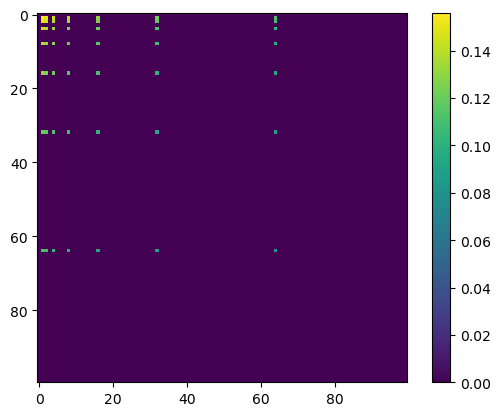

In [144]:
import matplotlib.pyplot as plt
plt.imshow(rho[:100, :100])
plt.colorbar()

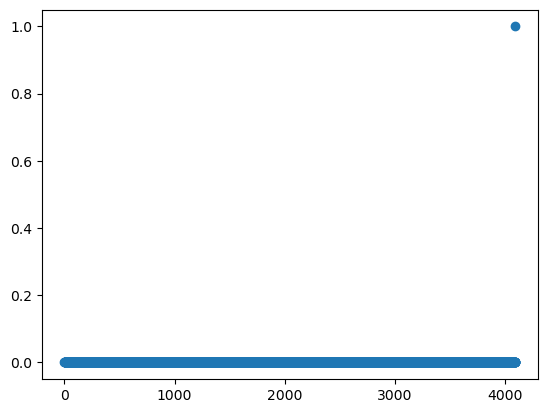